In this project, your goal is to write a software pipeline to identify the lane boundaries in a video, but the main output or product we want you to create is a detailed writeup of the project. Check out the [writeup template] for this project and use it as a starting point for creating your own writeup.  

The goals / steps of this project are the following:  

- Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.  
- Apply a distortion correction to raw images.  
- Use color transforms, gradients, etc., to create a thresholded binary image.  
- Apply a perspective transform to rectify binary image ("birds-eye view").  
- Detect lane pixels and fit to find the lane boundary.  
- Determine the curvature of the lane and vehicle position with respect to center.  
- Warp the detected lane boundaries back onto the original image.  
- Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.  

The images for camera calibration are stored in the folder called camera_cal. The images in test_images are for testing your pipeline on single frames. If you want to extract more test images from the videos, you can simply use an image writing method like cv2.imwrite(), i.e., you can read the video in frame by frame as usual, and for frames you want to save for later you can write to an image file.  

To help the reviewer examine your work, please save examples of the output from each stage of your pipeline in the folder called output_images, and include a description in your writeup for the project of what each image shows. The video called project_video.mp4 is the video your pipeline should work well on.  

The challenge_video.mp4 video is an extra (and optional) challenge for you if you want to test your pipeline under somewhat trickier conditions. The harder_challenge.mp4 video is another optional challenge and is brutal!  


---

## Step 1: Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.

Using the images provided in the /camera_cal folder, we calibrate our camera with the following:

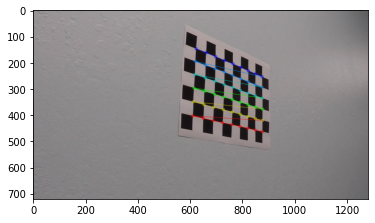

In [2]:
import numpy as np
import cv2
import glob
import pickle
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
from helper_functions import *

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (9,6), corners, ret)
        plt.imshow(img)

Now using this information, we create a calibration matrix

Text(0.5, 1.0, 'Undistorted Image')

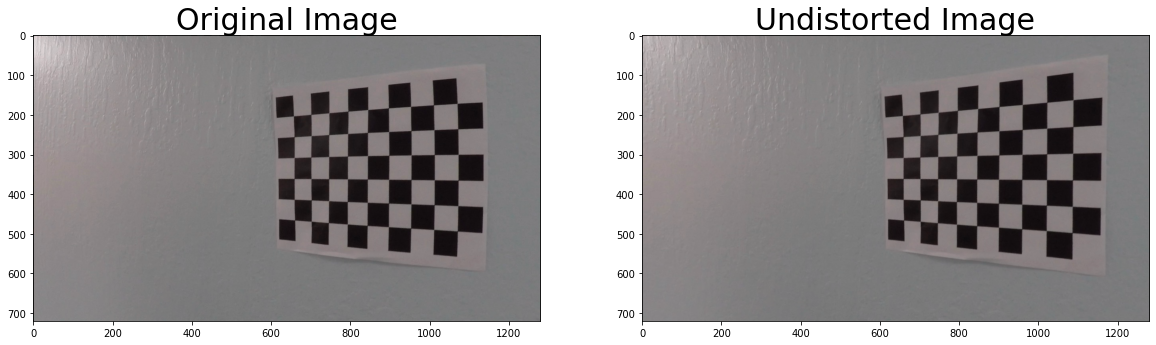

In [4]:
# Test undistortion on an image
img = cv2.imread('camera_cal/calibration12.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

dst = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('calibration_wide/test_undist.jpg',dst)

# Save the camera calibration result for later use (rvecs / tvecs not needed)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "camera_calibration_result.p", "wb" ) )
#dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

## Step 2: Apply a distortion correction to raw images.
Using the calibration matrix, apply the distortion correction to the image

Text(0.5, 1.0, 'Undistorted Image')

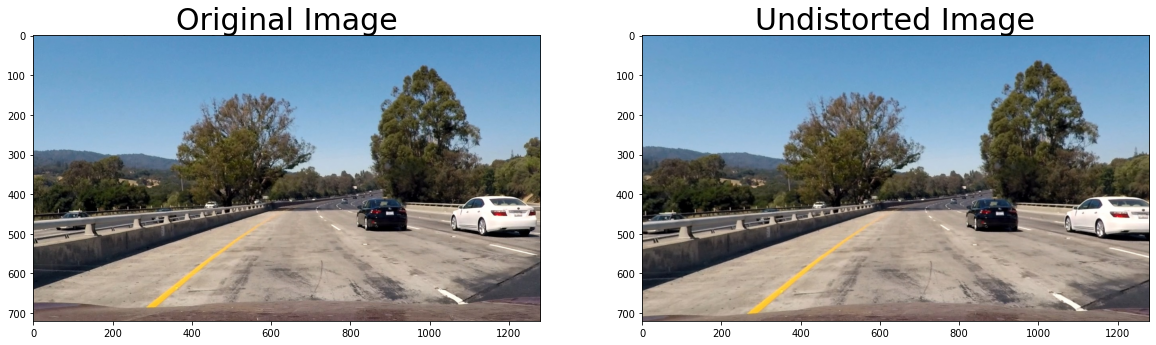

In [77]:
raw = cv2.imread("test_images/test1.jpg")
image_raw = cv2.cvtColor(raw,cv2.COLOR_BGR2RGB)
image = cv2.undistort(image_raw, mtx, dist, None, mtx)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(image_raw)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(image)
ax2.set_title('Undistorted Image', fontsize=30)

## Step 3: Apply a perspective transform to rectify image ("birds-eye view").

Next, a perspective transform is applied to the image so that the image appears in a 'birds-eye-view'.

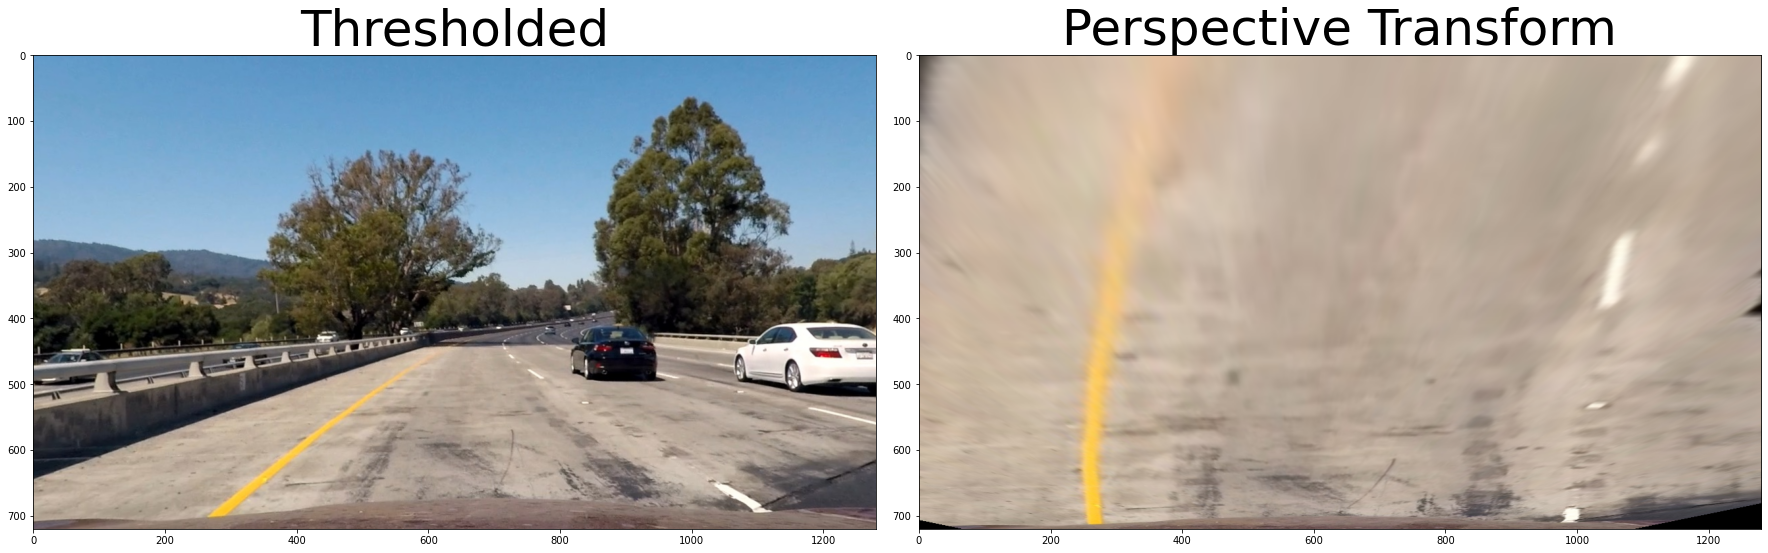

In [81]:
def perspective_transform(img):
    # define 4 source points for perspective transformation
    src = np.float32([[220,719],[1220,719],[750,480],[550,480]])
    # define 4 destination points for perspective transformation
    dst = np.float32([[240,719],[1040,719],[1040,300],[240,300]])
    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]))
    # Return the resulting image
    return warped, M

img_warped, M = perspective_transform(image)
display(image, 'Thresholded', img_warped, 'Perspective Transform')

## Step 4: Use color transforms, gradients, etc., to create a thresholded binary image.

Next, we apply a Sobel filter in the X direction (on a grayscaled image) and apply thresholding to filter out pixels that aren't of interest. We also convert the RGB image to HLS color space and use the S channel to pick out lane lines. 

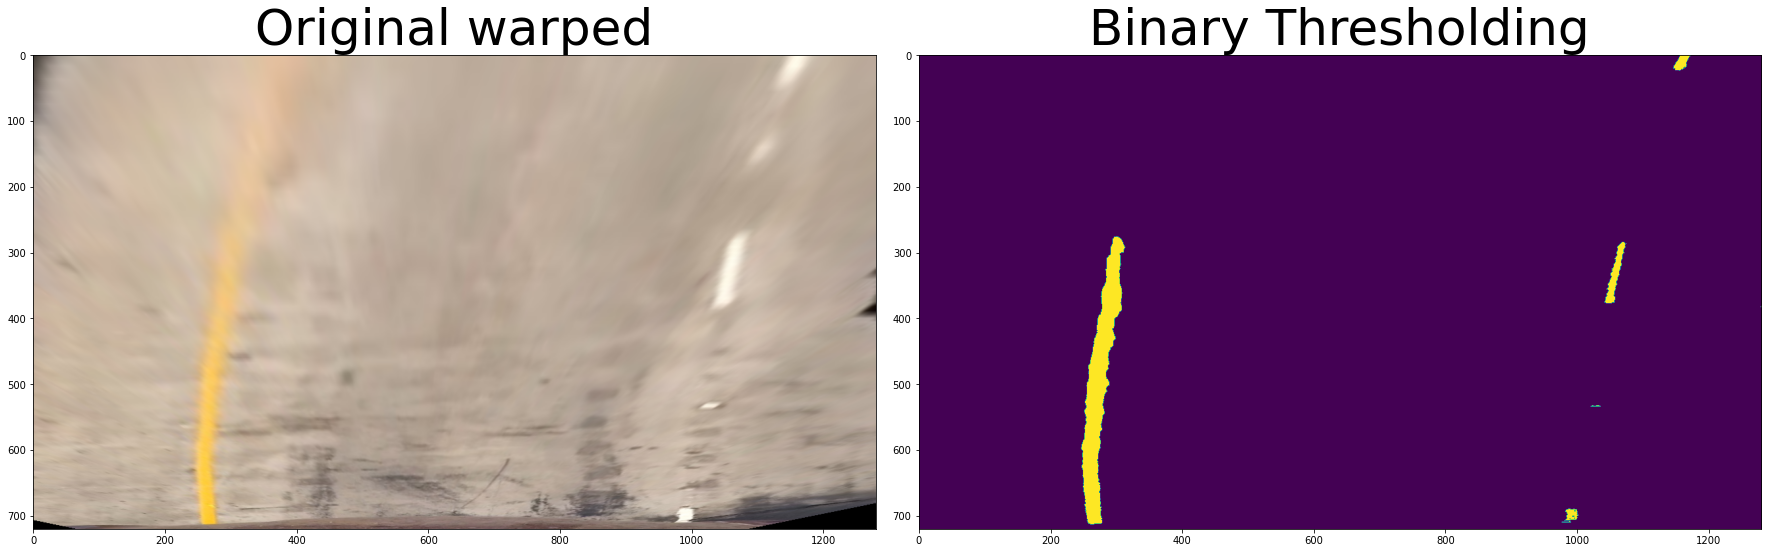

In [84]:
def abs_sobel_thresh(gray, sobel_kernel=3, thresh=(0, 255)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    # 3) Take the absolute value of the derivative or gradient
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    # 6) Return this mask as your binary_output image
    sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return binary_output

def binary_thresholding(img, s_thresh=(175, 250), sx_thresh=(30, 150)):
    # Convert to HLS color space and separate the S channel
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel
    ksize = 3
    sobel = abs_sobel_thresh(gray, sobel_kernel=ksize, thresh=sx_thresh)
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    combined = np.zeros_like(gray)
    combined[(s_binary == 1) | (sobel == 1)] = 1
    return s_binary

s_thresh = (175, 255)
sx_thresh = (30, 150)
binary_warped = binary_thresholding(img_warped, s_thresh=s_thresh, sx_thresh=sx_thresh)
display(img_warped, 'Original warped', binary_warped, 'Binary Thresholding')

## Step 5: Detect lane pixels and fit to find the lane boundary.

To extract the actual lane lines, we use a peak histogram technique. Two possible methods are used, the first being a Naive approach which brute force searches across the image using the histogram (sliding window) technique, and if this does not work then we use a smart approach which uses the line location from the previous image for prediction. Once all pixels have been detected, we use a polynomial fit to generate the lines.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


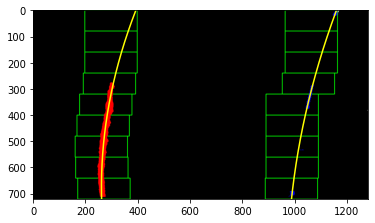

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


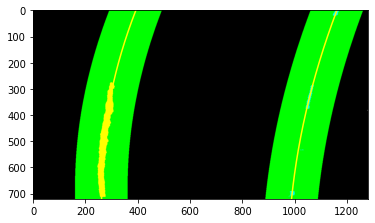

In [92]:
class Line():
    # We use this class to hold the details of the located lines and polynomial fit for each image.
    def __init__(self):
        self.fullsearch = False  
        self.left_lane_inds = None 
        self.right_lane_inds = None   
        self.left_fit = None  
        self.right_fit = None 
        self.left_fit_cr = None  
        self.right_fit_cr = None 
        self.yvals = None
        self.left_fitx = None
        self.right_fitx = None
        self.y_bottom = None
        self.y_top = None
        self.left_x_bottom = None
        self.left_x_top = None
        self.right_x_bottom = None
        self.right_x_top = None
        self.left_curverads = None
        self.right_curverads = None
        self.mean_left_curverad = None
        self.mean_right_curverad = None
        self.prev

def display_poly_fit(binary_warped, left_lane_inds, right_lane_inds, out_img, plotSearchArea=False):
    left_fit, right_fit = fit_curve(binary_warped, left_lane_inds, right_lane_inds)
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    # Generate x and y values for plotting
    fity = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    fit_leftx = left_fit[0]*fity**2 + left_fit[1]*fity + left_fit[2]
    fit_rightx = right_fit[0]*fity**2 + right_fit[1]*fity + right_fit[2]
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    result = None
    if plotSearchArea == True:
        window_img = np.zeros_like(out_img)
        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        left_line_window1 = np.array([np.transpose(np.vstack([fit_leftx-margin, fity]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([fit_leftx+margin, fity])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        right_line_window1 = np.array([np.transpose(np.vstack([fit_rightx-margin, fity]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([fit_rightx+margin, fity])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
        result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    else:
        result = out_img

    plt.imshow(result)
    plt.plot(fit_leftx, fity, color='yellow')
    plt.plot(fit_rightx, fity, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    plt.show()
    
def draw_lines(undist, warped, yvals, left_fitx, right_fitx, Minv):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, yvals]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, yvals])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (mtxinv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (color_warp.shape[1], color_warp.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    return result

def naive_find_lines(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    return left_lane_inds, right_lane_inds, out_img

def smart_find_lines(binary_warped, left_fit, right_fit):
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + 
        left_fit[1]*nonzeroy + left_fit[2] - margin)) & 
    (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + 
        right_fit[1]*nonzeroy + right_fit[2] - margin)) & 
    (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit_new = np.polyfit(lefty, leftx, 2)
    right_fit_new = np.polyfit(righty, rightx, 2)

    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    return left_lane_inds, right_lane_inds, out_img    

def fit_curve(binary_warped, left_lane_inds, right_lane_inds):
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    return left_fit, right_fit

def process_fit(binary_warped, left_lane_inds, right_lane_inds):
    left_fit, right_fit = fit_curve(binary_warped, left_lane_inds, right_lane_inds)
    left_fit_cr, right_fit_cr = fit_pixel_to_meters(binary_warped, left_lane_inds, right_lane_inds)
    yvals, left_fitx, right_fitx = fit_lines(binary_warped, left_fit, right_fit)

    line = Line()
    line.left_lane_inds = left_lane_inds
    line.right_lane_inds = right_lane_inds
    line.left_fit = left_fit
    line.right_fit = right_fit
    line.left_fit_cr = left_fit_cr
    line.right_fit_cr = right_fit_cr
    line.yvals = yvals
    line.left_fitx = left_fitx
    line.right_fitx = right_fitx
    line.y_bottom = np.min(yvals)
    line.y_top = np.max(yvals)
    line.left_x_bottom = left_fit[0]*line.y_bottom**2 + left_fit[1]*line.y_bottom + left_fit[2]
    line.left_x_top = left_fit[0]*line.y_top**2 + left_fit[1]*line.y_top + left_fit[2]
    line.right_x_bottom = right_fit[0]*line.y_bottom**2 + right_fit[1]*line.y_bottom + right_fit[2]
    line.right_x_top = right_fit[0]*line.y_top**2 + right_fit[1]*line.y_top + right_fit[2]
    left_curverads, right_curverads = radius_of_curvatures(line.yvals, left_fit_cr, right_fit_cr)
    line.left_curverads = left_curverads
    line.right_curverads = right_curverads
    line.mean_left_curverad = np.mean(left_curverads)
    line.mean_right_curverad = np.mean(right_curverads)

    return line

def fit_lines(binary_warped, left_fit, right_fit):
    yvals = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*yvals**2 + left_fit[1]*yvals + left_fit[2]
    right_fitx = right_fit[0]*yvals**2 + right_fit[1]*yvals + right_fit[2]
    return yvals, left_fitx, right_fitx

# naive search
left_lane_inds, right_lane_inds, out_img = naive_find_lines(binary_warped)
line = process_fit(binary_warped, left_lane_inds, right_lane_inds)
display_poly_fit(binary_warped, left_lane_inds, right_lane_inds, out_img, False)

# TODO: Make Smart Search viable (to work after the 1st frame, instead of naive find)
# # smart search (we are faking it here)
left_lane_inds, right_lane_inds, out_img = smart_find_lines(binary_warped, line.left_fit, line.right_fit)
line = process_fit(binary_warped, left_lane_inds, right_lane_inds)
display_poly_fit(binary_warped, left_lane_inds, right_lane_inds, out_img, True)

## Step 6: Determine the curvature of the lane and vehicle position with respect to center.
## Step 7: Warp the detected lane boundaries back onto the original image.
## Step 8: Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

From these polynomials, we can convert to real space and determine the radius of curvature of the road and the position of the car within the lane with the following:

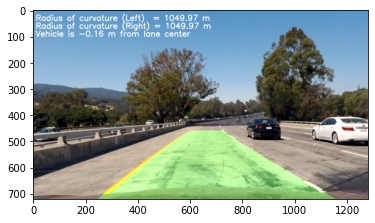

In [93]:
def fit_pixel_to_meters(binary_warped, left_lane_inds, right_lane_inds):
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    ''' Define conversions in x and y from pixels space to meters
     We assume the lane is about 30 meters long and 3.7 meters wide.
     Hence, distance in meters / distance in pixels = meters to pixels conversion ratio. '''
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    return left_fit_cr, right_fit_cr

def radius_of_curvatures(yvals, left_fit, right_fit):
    left_curverads = ((1 + (2*left_fit[0]*yvals + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverads = ((1 + (2*right_fit[0]*yvals + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    return left_curverads, right_curverads

def annotate_result(result, line):
    lx = line.left_x_top
    rx = line.right_x_top
    xcenter = np.int(result.shape[1]/2)
    offset = (rx - xcenter) - (xcenter - lx) 
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    vehicle_offset =  offset * xm_per_pix

    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(result, 'Radius of curvature (Left)  = %.2f m' % (line.mean_left_curverad), 
        (10, 40), font, 1, (255, 255, 255), 2, cv2.LINE_AA)
    cv2.putText(result, 'Radius of curvature (Right) = %.2f m' % (line.mean_left_curverad), 
        (10, 70), font, 1, (255, 255, 255), 2, cv2.LINE_AA)
    cv2.putText(result, 'Vehicle is %.2f m from lane center' % (vehicle_offset), 
               (10, 100), font, 1, (255, 255, 255), 2, cv2.LINE_AA)
    return result

result = draw_lines(image, binary_warped, line.yvals, line.left_fitx, line.right_fitx, np.linalg.inv(M))
annotated_result = annotate_result(result, line)
plt.imshow(result)
plt.show()

## Video Pipeline

In [8]:
output = process_video()

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [04:55<00:00,  4.03it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

Num full searches 280
